Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-295f7a4cc821>:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-5-295f7a4cc821>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-5-295f7a4cc821>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20], Train Loss: 0.9601, Train Accuracy: 0.6104, Validation Loss: 0.4696, Validation Accuracy: 0.8228
Model saved as best_model.pth with validation loss: 0.4696
Epoch [2/20], Train Loss: 0.3522, Train Accuracy: 0.8729, Validation Loss: 0.3307, Validation Accuracy: 0.8728
Model saved as best_model.pth with validation loss: 0.3307
Epoch [3/20], Train Loss: 0.2392, Train Accuracy: 0.9197, Validation Loss: 0.3023, Validation Accuracy: 0.8775
Model saved as best_model.pth with validation loss: 0.3023
Epoch [4/20], Train Loss: 0.1832, Train Accuracy: 0.9363, Validation Loss: 0.3618, Validation Accuracy: 0.8894
Epoch [5/20], Train Loss: 0.1673, Train Accuracy: 0.9446, Validation Loss: 0.3223, Validation Accuracy: 0.9049
Epoch [6/20], Train Loss: 0.1467, Train Accuracy: 0.9446, Validation Loss: 0.4622, Validation Accuracy: 0.8894
Epoch [7/20], Train Loss: 0.1088, Train Accuracy: 0.9609, Validation Loss: 0.2441, Validation Accuracy: 0.9108
Model saved as best_model.pth with validation 

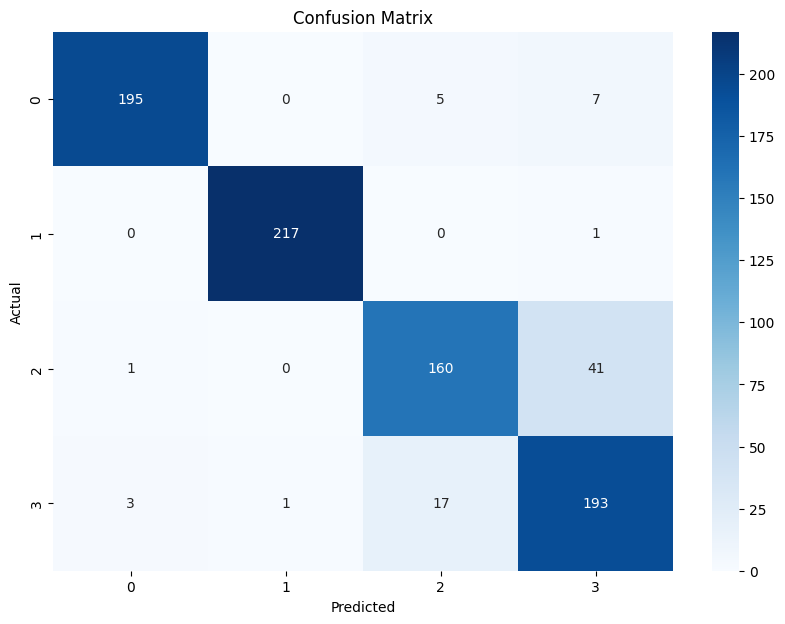

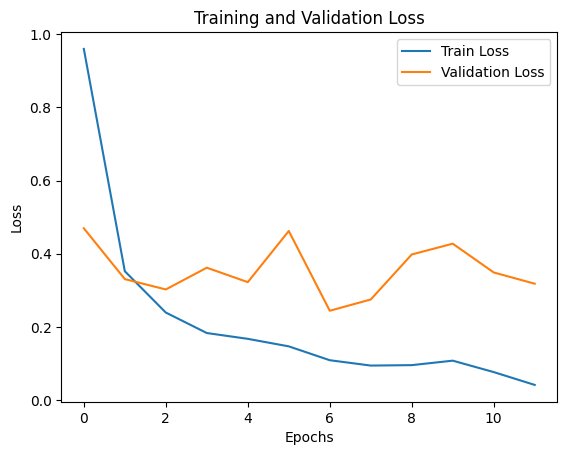

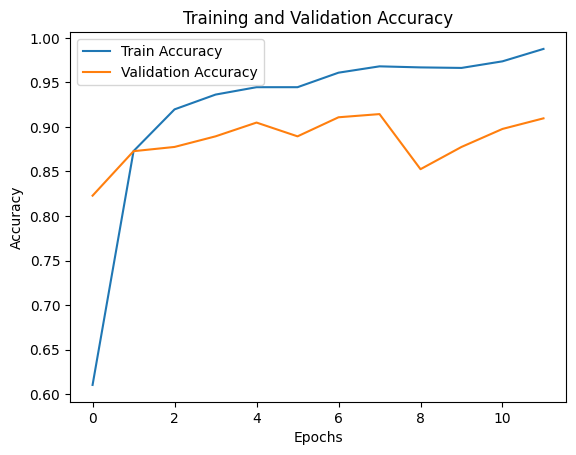

Final validation accuracy using the best model:  0.9096313912009513


<ipython-input-5-295f7a4cc821>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
!pip install torch-optimizer  # Install the 'torch-optimizer' package
import torch_optimizer as optim_ext  # For RAdam and other optimizers
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

# Mount Google Drive
drive.mount('/content/drive')

# Define directories for training and testing data
train_dir = '/content/drive/MyDrive/Dataset_cross/Train'
test_dir = '/content/drive/MyDrive/Dataset_cross/Test'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Define the hybrid model using EfficientNet-B3
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)  # EfficientNet-B3
        num_features = self.base_model.classifier[1].in_features
        self.base_model.classifier[1] = nn.Linear(num_features, len(train_data.classes))  # Set output size to number of classes

    def forward(self, x):
        return self.base_model(x)

# Instantiate the model
model = HybridModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim_ext.RAdam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2, verbose=True)

# Mixed precision training
scaler = GradScaler()

# Training and validation function
def train_validate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    early_stop_patience = 5
    stop_count = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = total_val_loss / len(test_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Reduce learning rate if validation loss has stopped improving
        scheduler.step(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping and model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            stop_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model saved as best_model.pth with validation loss: {val_loss:.4f}")
        else:
            stop_count += 1
            if stop_count >= early_stop_patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels

# Train and validate the model
train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_validate_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Load and evaluate best model
model.load_state_dict(torch.load('best_model.pth'))
print("Final validation accuracy using the best model: ", accuracy_score(all_labels, all_preds))
